In [1]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as appl
from sklearn.model_selection import train_test_split
import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from keras import callbacks  
from keras.models import load_model
from keras.utils import np_utils


In [2]:
# parameters

CATEGORIES = ['bull','camel','cat','cow','crocodile','deer','dog','elephant','goat','horse','lion','snake','tiger']
cat_len=len(CATEGORIES)
IMG_SIZE = 224

X=np.load('D:/Agrima/animals_SpatialData_handpicked/X_1.npy', allow_pickle=True)
Y=np.load('D:/Agrima/animals_SpatialData_handpicked/Y_1.npy', allow_pickle=True)
# X=np.load('D:/Agrima/animals_IM_white_spatial/X.npy', allow_pickle=True)
# Y=np.load('D:/Agrima/animals_IM_white_spatial/Y.npy', allow_pickle=True)


In [3]:
# model

# model_name1 = 'InceptionResNetV2'
model_name1 = '4layer'
model_name2 = 'VGG16'
# model_name1 = 'DenseNet121'
# model_name1 = 'InceptionV3'

In [4]:
print('Splitting') 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = cat_len)
X_train, X_new, y_train, y_new = train_test_split(X_train, y_train, test_size = 0.2, random_state = cat_len)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_new = np.array(X_new)
y_new = np.array(y_new)

print('Image Data Augmentation')
from keras.preprocessing.image import ImageDataGenerator
val_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2)
#                                    , horizontal_flip=True, brightness_range=[0.6,1.3])
val_generator.fit(X_train)
val_generator.fit(X_new)
val_generator.fit(X_test)

print('Data generator')
# class DataGenerator(Sequence):
#     def __init__(self, x_set, y_set, batch_size):
#         self.x, self.y = x_set, y_set
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.x) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return batch_x, batch_y
# train_gen = DataGenerator(X_train, y_train, 16)
# test_gen = DataGenerator(X_test, y_test, 16)
# new_gen = DataGenerator(X_new, y_new, 16)

Splitting
Image Data Augmentation
Data generator


In [5]:
# model
def make_model(model_name1,cat_len):
    if model_name1 == '4layer':
        model1 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(cat_len,  activation=tf.nn.softmax)])
    else:
        exec('from tensorflow.keras.applications import '+ model_name1,  None, globals())
        exec('MODEL = '+model_name1+'(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights=\'imagenet\')'
             , None, globals())
    
        for layers in MODEL.layers: 
            layers.trainable=False   
        input_layer = MODEL.output
        Conv1 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid',
               data_format='channels_last', activation='relu', 
               kernel_initializer=keras.initializers.he_normal(seed=0), 
               name='Conv1')(input_layer)
        Pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid', 
                  data_format='channels_last',name='Pool1')(Conv1)
        flatten = Flatten(data_format='channels_last',name='Flatten')(Pool1)
        FC1 = Dense(units=30, activation='relu', 
            kernel_initializer=keras.initializers.glorot_normal(seed=32), 
            name='FC1')(flatten)
        FC2 = Dense(units=30, activation='relu', 
            kernel_initializer=keras.initializers.glorot_normal(seed=33),
            name='FC2')(FC1)
        Out = Dense(units=cat_len, activation='softmax', 
            kernel_initializer=keras.initializers.glorot_normal(seed=3), 
            name='Output')(FC2)
        model1 = Model(inputs=MODEL.input,outputs=Out)
    return model1
model1 = make_model(model_name1,cat_len)
model2 = make_model(model_name2,2)

In [6]:
def similar_data(X_train,y_train):      
    bull_cow_train = np.where((y_train[:,6]==1) | (y_train[:,12]==1))    
    X_train2 = np.squeeze(np.take(X_train,bull_cow_train, axis = 0),axis = 0)
    y_train20 = np.squeeze(np.take(y_train,bull_cow_train, axis = 0),axis = 0)
    y_train2=np.zeros((y_train20.shape[0],2))
    bull = np.where((y_train20[:,6]==1))
    cow = np.where((y_train20[:,12]==1))
    y_train2[bull]=[1,0]
    y_train2[cow]=[0,1]
    return X_train2, y_train2, bull_cow_train

X_train2, y_train2, bull_cow_train = similar_data(X_train,y_train)
X_test2, y_test2, bull_cow_test = similar_data(X_test,y_test)
X_new2, y_new2, bull_cow_new = similar_data(X_new,y_new)

# train_gen2 = DataGenerator(X_train2, y_train2, 16)
# test_gen2 = DataGenerator(X_test2, y_test2, 16)
# new_gen2 = DataGenerator(X_new2, y_new2, 16)

In [7]:
print('Training model 1')
earlystopping = callbacks.EarlyStopping(monitor="val_loss", patience = 5, restore_best_weights = True)
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# model1.summary()


history_const = model1.fit(X_train, y_train,batch_size=150, epochs = 30, validation_data=(X_test,y_test),
                   callbacks= [earlystopping])


model1 = load_model('D:/Agrima/animals_SpatialData_handpicked/vishal/'+model_name1+'_model.h5')
# history_const=np.load('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+'_history.npy',allow_pickle='TRUE').item()
print('Training model 2')
# model2 = load_model('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+'_bull_cow_model.h5') 
#history_const2=np.load('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+'_bull_cow_history.npy',allow_pickle='TRUE').item()


#model2 = load_model('D:/Agrima/animals_SpatialData_handpicked/'+model_name2+'_tiger_dog_model.h5') 

earlystopping = callbacks.EarlyStopping(monitor="val_loss", patience = 5, restore_best_weights = True)
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history_const2 = model2.fit(X_train2, y_train2, batch_size=150, epochs = 30, validation_data=(X_test2, y_test2),
                   callbacks= [earlystopping])
# #model2 = load_model('D:/Agrima/animals_SpatialData_handpicked/'+model_name2+'_tiger_dog_model.h5') 

# print('Saving')
# np.save('D:/Agrima/animals_SpatialData_handpicked/'+model_name2+'_tiger_dog_history.npy',history_const2.history)
# np.save('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+'_history.npy',history_const.history)
# model2.save('D:/Agrima/animals_SpatialData_handpicked/'+model_name2+'_tiger_dog_model_1.h5') 
# model1.save('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+'_model_1.h5') 
# #history_const2=np.load('D:/Agrima/animals_SpatialData_handpicked/'+model_name2+'_tiger_dog_history.npy',allow_pickle='TRUE').item()


Training model 1
Training model 2
Epoch 1/30
7/7 [==============================] - 12s 860ms/step - loss: 0.6066 - accuracy: 0.6770 - val_loss: 0.5519 - val_accuracy: 0.7227
Epoch 2/30
7/7 [==============================] - 2s 313ms/step - loss: 0.4752 - accuracy: 0.7896 - val_loss: 0.5042 - val_accuracy: 0.7264
Epoch 3/30
7/7 [==============================] - 2s 310ms/step - loss: 0.3707 - accuracy: 0.8554 - val_loss: 0.4087 - val_accuracy: 0.7893
Epoch 4/30
7/7 [==============================] - 2s 309ms/step - loss: 0.2922 - accuracy: 0.9013 - val_loss: 0.3210 - val_accuracy: 0.8595
Epoch 5/30
7/7 [==============================] - 2s 308ms/step - loss: 0.2180 - accuracy: 0.9392 - val_loss: 0.2577 - val_accuracy: 0.9002
Epoch 6/30
7/7 [==============================] - 2s 317ms/step - loss: 0.1611 - accuracy: 0.9621 - val_loss: 0.2176 - val_accuracy: 0.9316
Epoch 7/30
7/7 [==============================] - 2s 311ms/step - loss: 0.1187 - accuracy: 0.9771 - val_loss: 0.1879 - val_ac

In [8]:
# print('Saving')
# np.save('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+'_bull_cow_history.npy',history_const2.history)
# model1.save('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+'_bull_cow_model.h5') 
# history_const=np.load('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+'_bull_cow_history.npy',allow_pickle='TRUE').item()


Confusion matrix


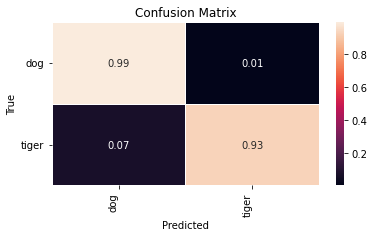

In [9]:
print('Confusion matrix')
Y_pred = model2.predict(X_new2)
y_pred = np.argmax(Y_pred, axis=1)
y_test1 = np.argmax(y_new2, axis=1)
cm=metrics.confusion_matrix(y_test1, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
a4_dims = (6, 3)
fig,ax= plt.subplots(figsize=a4_dims)
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax,  linewidth=.5);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(['dog','tiger'])
ax.set_yticklabels(['dog','tiger'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
# plt.savefig('D:/Agrima/animals_SpatialData_handpicked/'+model_name2+'_tiger_dog_cm_1.png',bbox_inches='tight')
plt.show()

Confusion matrix


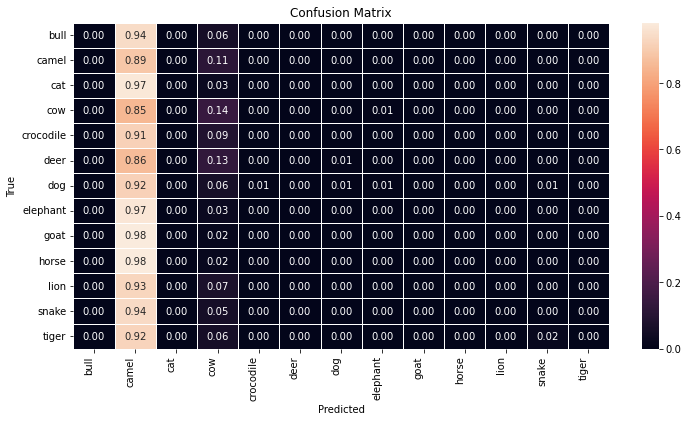

In [10]:
print('Confusion matrix')
Y_pred = model1.predict(X_new)
# new_gen2np = np.array(new_gen)
y_pred = np.argmax(Y_pred, axis=1)
Y0 = np_utils.to_categorical(y_pred, cat_len)
X,Y, bull_cow_pred = similar_data(X_new,Y0)
# print(Y_pred,X.shape, Y.shape)
# pred_gen2 = DataGenerator(X,Y, 16)
Y_pred_fin = model2.predict(X)
Y_pred[bull_cow_pred,6] = Y_pred_fin[:,0]
Y_pred[bull_cow_pred,12] = Y_pred_fin[:,1]

y_pred = np.argmax(Y_pred, axis=1)
y_test1 = np.argmax(y_new, axis=1)
cm=metrics.confusion_matrix(y_test1, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
a4_dims = (12, 6)
fig,ax= plt.subplots(figsize=a4_dims)
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax,  linewidth=.5);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(CATEGORIES)
ax.set_yticklabels(CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')

#plt.savefig('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+model_name2+'_after_cascade_tiger_dog_cm_1.png',bbox_inches='tight')
plt.show()

# print('Classification report')
# print(metrics.classification_report(y_test1, y_pred, target_names=CATEGORIES))

Confusion matrix


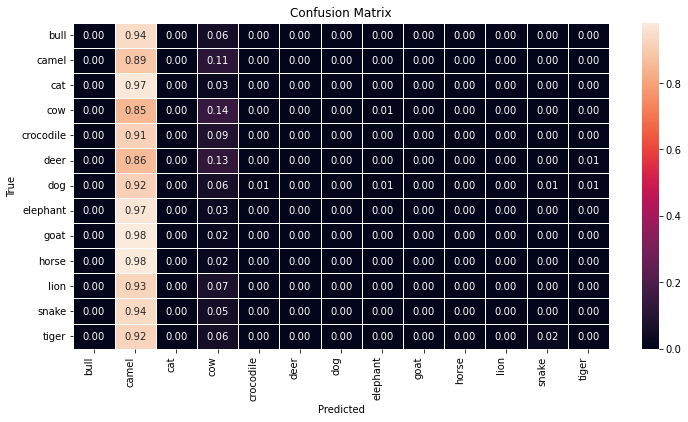

In [11]:
print('Confusion matrix')
Y_pred = model1.predict(X_new)
y_pred = np.argmax(Y_pred, axis=1)
y_test1 = np.argmax(y_new, axis=1)

cm=metrics.confusion_matrix(y_test1, y_pred)


cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
a4_dims = (12, 6)
fig,ax= plt.subplots(figsize=a4_dims)
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax,  linewidth=.5);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(CATEGORIES)
ax.set_yticklabels(CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
# plt.savefig('D:/Agrima/animals_SpatialData_handpicked/'+model_name1+'_before_cascade_cm_1.png',bbox_inches='tight')
plt.show()

# print('Classification report')
# print(metrics.classification_report(y_test1, y_pred, target_names=CATEGORIES))

Predicted Label:  camel
True Label:  lion


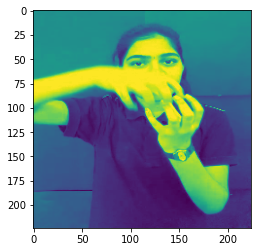

In [12]:
#CHECK RANDOM IMAGES FROM TESTED DATA WHETHER RIGHT OR WRONG

i = random.randint(1,cat_len)
plt.imshow(X_new[i,:,:,2]) 
print("Predicted Label: ", CATEGORIES[int(y_pred[i])])
print("True Label: ", CATEGORIES[int(y_test1[i])])

([<matplotlib.axis.XTick at 0x1d117751310>,
 [Text(0, 0, 'bull'),
  Text(1, 0, 'camel'),
  Text(2, 0, 'cat'),
  Text(3, 0, 'cow'),
  Text(4, 0, 'crocodile'),
  Text(5, 0, 'deer'),
  Text(6, 0, 'dog'),
  Text(7, 0, 'elephant'),
  Text(8, 0, 'goat'),
  Text(9, 0, 'horse'),
  Text(10, 0, 'lion'),
  Text(11, 0, 'snake'),
  Text(12, 0, 'tiger')])

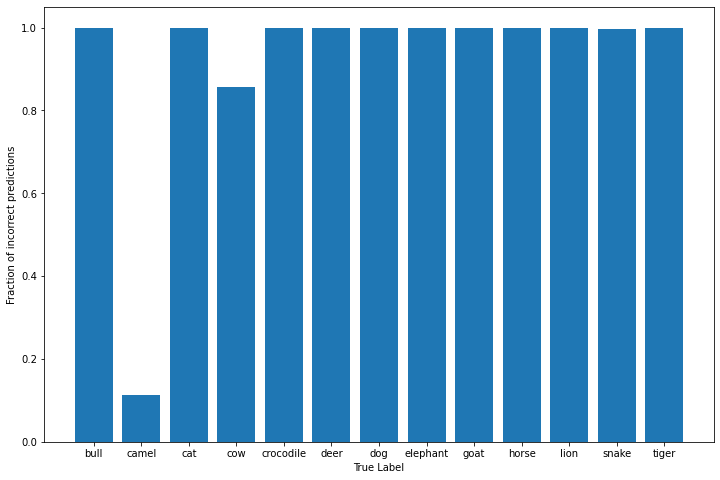

In [13]:
#PLot fractional incorrect misclassifications

incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

fig, ax = plt.subplots(figsize=(12,8))
plt.bar(np.arange(cat_len), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(cat_len), CATEGORIES)

In [14]:
X_new.shape

(2426, 224, 224, 3)